<a href="https://colab.research.google.com/github/A-Jouini/predict-SP-500-with-historical-data/blob/main/predict_tomorrow's_S%26P_500_index_price_using_historical_data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf

In [2]:
sp500 = yf.Ticker("^GSPC")

In [4]:
sp500 = sp500.history(period="max")

In [5]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-09 00:00:00-05:00,6917.259766,6980.100098,6905.870117,6964.819824,5650260000,0.0,0.0
2026-02-10 00:00:00-05:00,6974.490234,6986.830078,6937.529785,6941.810059,5595950000,0.0,0.0
2026-02-11 00:00:00-05:00,6976.479980,6993.479980,6911.970215,6941.470215,6175510000,0.0,0.0


<Axes: xlabel='Date'>

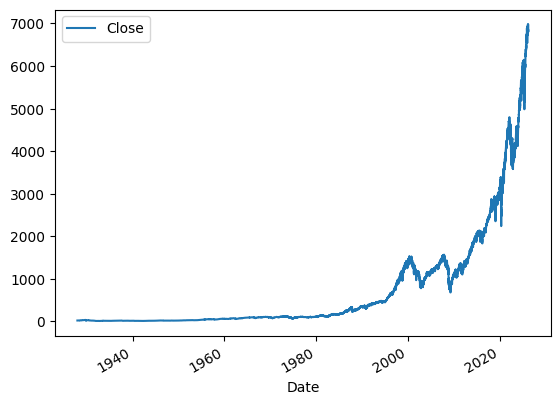

In [6]:
sp500.plot.line(y="Close", use_index =True)

In [7]:
del sp500['Dividends']
del sp500['Stock Splits']

In [9]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [10]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [11]:
sp500 = sp500.loc["1990-01-01":].copy()

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [14]:
train = sp500.iloc[:-100]

In [15]:
test = sp500.iloc[-100:]

In [16]:
predictors = ["Close","Volume","Open","High","Low"]

In [18]:
model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [19]:
from sklearn.metrics import precision_score

In [20]:
preds = model.predict(test[predictors])

In [21]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [22]:
precision_score(test["Target"],preds)

0.5753424657534246

In [23]:
combined =pd.concat([test["Target"],preds],axis=1)

<Axes: xlabel='Date'>

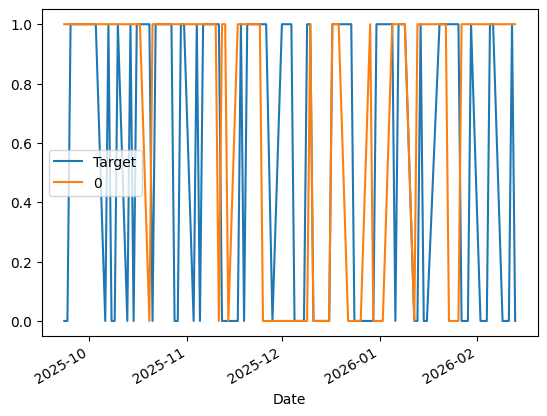

In [24]:
combined.plot()

**BackTesting**

In [25]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [26]:
def backtest(data,model,predictors,start=2500,step=250):
  all_predictions = []

  for i in range(start,data.shape[0],step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train,test,predictors,model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [27]:
predictions = backtest(sp500,model,predictors)

In [28]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5307116104868914

**Additional Predictors**

In [29]:
horizons = [2,5,60,250,100]

In [33]:
new_predictors = []
for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()
  ration_column = f"Close_Ratio_{horizon}"
  sp500[ration_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ration_column,trend_column]

In [35]:
sp500.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Tomorrow,1
Target,0
Close_Ratio_2,1
Trend_2,2
Close_Ratio_5,4


In [36]:
sp500=sp500.dropna()

**Improving the Model**

In [37]:
model = RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [38]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >=.6] = 1
  preds[preds <.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [39]:
predictions = backtest(sp500,model,new_predictors)

In [40]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5781409601634321